# Conectando Cosas: medición de luz usando un foto-resistor.


## Objetivo

El objetivo de esta clase es realizar la medición de luz utilizando un foto-resistor y el conversor A/D del Arduino. La salida será graficada con el Serial Plotter.

La salida deberá estar en *lux*, la medida estándar de intensidad luminosa sobre una superficie. Para ello, debemos

1. Medir el valor de caída de tensión en el foto-resistor.
2. Convertir el valor a una resistencia medida.
3. Convertir la resistencia a *lux* utilizando los parámetros de funcionamiento del fotoresistor (hoja de datos).
4. Ajustar el circuito y el código para que el rango de medida sea adecuado.


## Divisor Resistivo.

Para medir la resistencia, se utiliza un simple divisor resistivo, según el siguiente diagrama:

![divisor resistivo](https://github.com/ORTConectandoCosas/ldr-to-lux/raw/master/voltage%20divider1.png "Divisor Resistivo")


En nuestro caso $R_1$ es $R_0$, una resistencia a elegir y $R_2$ es $R_{ldr}$ la resistencia a medir.

De la Ley de Ohm, se tiene que:

$$ V_{cc} = (R_0 + R_{ldr}) I,$$

de donde:

$$ i = \frac{V_{cc}}{R_0 + R_{ldr}}. $$

Por lo tanto la tensión en bornes del fotoresistor es:

$$ V_{in} = \frac{R_{ldr}}{R_0 + R_{ldr}} V_{cc}. $$



## Conversión Analógica - Digital

El conversor Analógico-Digital del Arduino convierte un valor de tensión en el pin en un número de 10 bits (conversión A/D de 10 bits de resolución). El comportamiento es lineal entre $0$, correspondiente a $V_{in}=0$, y $2^{10}-1 = 1023$, correspondiente a $V_{in}=V_{cc}$.

Sea $x$ el valor que lee el conversor A/D, se cumple entonces que:

$$ \frac{x}{1024} = \frac{V_{in}}{V_{cc}}. $$

Usando la ecuación anterior tenemos que:

$$ \frac{x}{1024} = \frac{R_{ldr}}{R_0 + R_{ldr}}, $$

de donde, despejando:

$$ R_{ldr} = R_0 \left(\frac{x}{1024-x}\right).$$



## Conversión Analógica - Digital: medida de la resistencia

Grafiquemos la relación anterior:

$$ R_{ldr} = R_0 \left(\frac{x}{1024-x}\right).$$

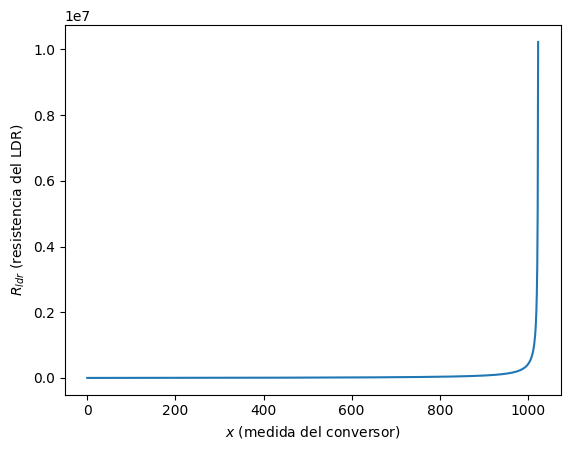

In [1]:
using PyPlot

x=(0:1024);
R0=10e3;
max_x = 1024.0;

R = R0*(x./(1024.0-x));

plot(x,R);
xlabel(L"$x$ (medida del conversor)");
ylabel(L"$R_{ldr}$ (resistencia del LDR)");

## Escala logarítmica.

La gráfica anterior muestra que la relación entre $x$ y $R_{ldr}$ es altamente no lineal. Sin embargo, el LDR tiene una respesta logarítmica, por lo que nos interesa más ver qué ocurre con $\log(R_{ldr})$. Hagamos una nueva gráfica:

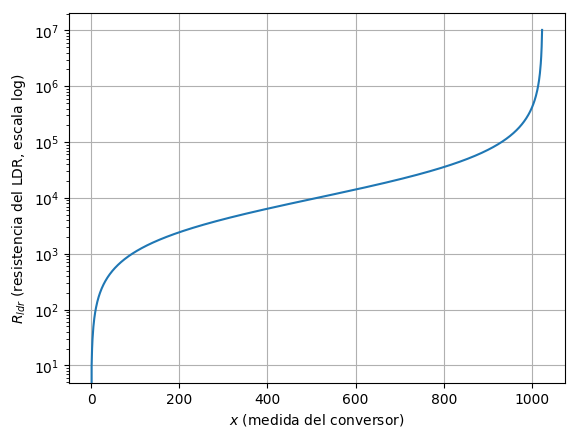

In [2]:
semilogy(x,R);
xlabel(L"$x$ (medida del conversor)");
ylabel(L"$R_{ldr}$ (resistencia del LDR, escala log)");
grid()

## El rol de $R_0$.

De la gráfica anterior, se ve que la respuesta en escala logarítmica es satisfactoria entre aproximadamente $x=100$ y $x=900$. Es decir, entre estos valores es posible discernir el valor de la resistencia con mayor precisión. Para $x<100$ o $x>900$ pequeños errores en la medida $x$ producen altos errores en la medición de la resistencia.

La gráfica anterior vale $R_{ldr} = R_0 = 10k$ para $x=512$, el centro del rango. Por lo tanto, $R_0$ debe elegirse de manera que la resistencia típica del LDR *en el centro del rango a medir* sea aproximadamente igual a $R_0$. De este modo nos aseguramos que el valor típico quede en el centro del rango de medida.

## Curva de respuesta del LDR.

Debemos ahora estudiar cómo varía la resistencia $R_{ldr}$ con la intensidad luminosa. Para ello consultamos la hoja de datos del LDR. Allí vemos la siguiente figura (puede variar dependiendo del LDR, pero todas siguen la misma esencia):

![LDR response](https://github.com/ORTConectandoCosas/ldr-to-lux/raw/master/lum_response.png "Curva de respuesta del LDR")

La gráfica anterior nos muestra una relación lineal en escala logarítmica entre los *lux* de intensidad lumínica y la resistencia $R_{ldr}$. La relación anterior puede escribirse como:

$$ \log\left(\frac{R_{ldr}}{R_b}\right) = -\gamma \log\left(\frac{I}{I_{b}}\right).$$

Donde:

* $R_b$ es la resistencia del LDR cuando la intensidad de luz es $I_b$.
* $\gamma$ es un parámetro que caracteriza cuánto decae la resistencia con la luz.

De la hoja de datos tenemos:

* $\gamma$ = 0.7.
* $R_b \in [18,50] k\Omega$ a $I_b = 10$ lux.

A los efector prácticos, y a falta de calibración, tomaremos esta resistencia como el valor representativo $R_b=30k\Omega$.

## Obteniendo la cantidad de *lux*.

Para hallar la intensidad luminosa, debemos despejar $I$ en la ecuación anterior. Tomando exponencial de ambos lados y usando propiedades se tiene que:

$$ \frac{R_{ldr}}{R_b} = \left(\frac{I}{I_b}\right)^{-\gamma}.$$

Por lo tanto, despejando la intensidad:

$$ I = I_b \left(\frac{R_{ldr}}{R_b}\right)^{-1/\gamma}.$$

Para los valores anteriores del LDR la ecuación anterior se resume en:

$$ I = 10 \left(\frac{R_{ldr}}{30k}\right)^{-1.43}.$$


## Obteniendo la cantidad de *lux* de la lectura.

Combinando las ecuaciones anteriores llegamos a la fórmula que vincula la medida del A/D $x$ y la intensidad $I$:

$$ I = I_b \left(\frac{R_0}{R_b}\left(\frac{x}{1024-x}\right)\right)^{-1/\gamma}.$$ 

Grafiquemos lo anterior para $I_b=10$ lux, $R_0=10k$, $R_b=30k$ y $\gamma=0.7$:

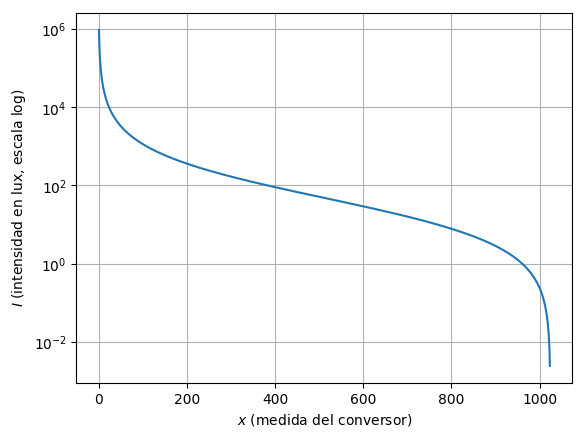

In [3]:
Ib=10.0;
R0=10e3;
Rb=30e3;
gamma=0.7;

x=(0:1023);

I=Ib*(R0/Rb*(x./(1024.0-x))).^(-1/gamma);

semilogy(x,I);
grid();
xlabel(L"$x$ (medida del conversor)");
ylabel(L"$I$ (intensidad en lux, escala log)");

## Ejemplos de intensidad luminosa (de Wikipedia).

De la gráfica anterior, con este LDR y el circuito armado podemos medir razonablemente de 1 a 1000 lux.
Para tener una referencia:

| Lux        | Situación  |                           
|----------|----------|
|0.0001	     |Moonless, overcast night sky (starlight)|
|0.002	     |Moonless clear night sky with airglow|
|0.05–0.3	 |Full moon on a clear night|
|3.4	     |Dark limit of civil twilight under a clear sky|
|20–50	     |Public areas with dark surroundings|
|50	         |Family living room lights|
|80	         |Office building hallway/toilet lighting|
|100	     |Very dark overcast day|
|150	     |Train station platforms|
|320–500	 |Office lighting|
|400	     |Sunrise or sunset on a clear day.|
|1000	     |Overcast day; typical TV studio lighting|
|10,000–25,000	|Full daylight (not direct sun)|
|32,000–100,000	|Direct sunlight|

## Calibración de sensores

El procedimiento anterior es aproximado: en la práctica, un sensor debe ser **calibrado** adecuadamente. En este caso, correspondería calibrar el sensor para conocer su $R_b$ y $\gamma$ en condiciones controladas de prueba. 

Como se vio $R_b$ puede variar bastante: se debe colocar el sensor en una habitación oscura con exactamente 10 lux cayendo sobre él, y allí medir $R_b$.

Esto se hace en laboratorios de fotometría (en Uruguay, en FING hay uno). Otros sensores son calibrados en el LATU, Laboratorio de UTE, etc.